# 本気出す

[【GAN + PyTorch】仕組みの解説とMNISTで画像生成 - ころがる狸](https://dajiro.com/entry/2020/05/23/153958)

In [2]:
import torch
from torch import nn, optim
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F
import matplotlib.pyplot as plt

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [3]:
from torchvision.datasets import MNIST
from torchvision import transforms

train_data = True
mnist = MNIST(
    root='./data',
    train=train_data,
    transform=transforms.ToTensor(),
    download=True)

1.7%

100.0%


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



102.8%


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100.0%


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



112.7%

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [4]:
class Generator(nn.Module):
    def __init__(self, input_size = 100, hid1_size = 256,
                 hid2_size = 512, hid3_size = 1024, batch_size = 4):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hid1_size)
        self.fc2 = nn.Linear(hid1_size, hid2_size)
        self.fc3 = nn.Linear(hid2_size, hid3_size)
        self.fc4 = nn.Linear(hid3_size, 28 * 28 * 1)
    
        self.bn1 = nn.BatchNorm1d(hid1_size)
        self.bn2 = nn.BatchNorm1d(hid2_size)
        self.bn3 = nn.BatchNorm1d(hid3_size)
        
        self.LeakyReLU = nn.LeakyReLU(0.2)
    
    def forward(self, x):
        x = self.LeakyReLU(self.fc1(x))
        x = self.bn1(x)
        x = self.LeakyReLU(self.fc2(x))
        x = self.bn2(x)
        x = self.LeakyReLU(self.fc3(x))
        x = self.bn3(x)
        x = torch.sigmoid(self.fc4(x))
        return x

class Discriminator(nn.Module):
    def __init__(self, hid1_size = 1024, hid2_size = 512,
                 hid3_size = 256, batch_size = 4):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Linear(784, hid1_size)
        self.fc2 = nn.Linear(hid1_size, hid2_size)
        self.fc3 = nn.Linear(hid2_size, hid3_size)
        self.fc4 = nn.Linear(hid3_size, 1)
    
        self.LeakyReLU = nn.LeakyReLU(0.2)
    
    def forward(self, x):
        x = self.LeakyReLU(self.fc1(x))
        x = self.LeakyReLU(self.fc2(x))
        x = self.LeakyReLU(self.fc3(x))
        x = torch.sigmoid(self.fc4(x))
        return x

In [9]:
def train(netD, netG, optimD, optimG, image):
    batch_size = len(image)
    label_real = torch.full((batch_size, 1), 1.).to(device)
    label_fake = torch.full((batch_size, 1), 0.).to(device)


    y_real = netD(image)
    lossD_real = F.binary_cross_entropy(y_real, label_real)

    noise = torch.randn((batch_size, 100)).to(device)
    fake = netG(noise)
    y_fake = netD(fake)
    lossD_fake = F.binary_cross_entropy(y_fake, label_fake)

    lossD = lossD_real + lossD_fake
    lossD.backward(retain_graph=True)
    optimD.step()

    y_fake = netD(fake)
    lossG = F.binary_cross_entropy(y_fake, label_real)
    lossG.backward(retain_graph=True)
    optimG.step()


    return lossD, lossG

def write(model, w=5, h=1, size=2):
    n = w*h
    x = torch.randn(n, 100).to(device)
    images = model(x)
    plt.figure(figsize=(size*w, size*h))
    for i in range(n):
        plt.subplot(h, w, i+1)
        img = images[i].reshape(28, 28).cpu().detach().numpy()
        plt.imshow(img, cmap="gray")
        plt.tick_params(
            labelbottom=False,
            labelleft=False,
            labelright=False,
            labeltop=False)
        plt.tight_layout()
    plt.show()

In [24]:
batch_size = 128
lr = 0.0001
dataloader = DataLoader(dataset=mnist, batch_size=batch_size)

netD = Discriminator()
netG = Generator()
netD.to(device)
netG.to(device)
optimD = optim.Adam(netD.parameters(), lr=lr)
optimG = optim.Adam(netG.parameters(), lr=lr)

In [25]:
epochs = 30

初期状態


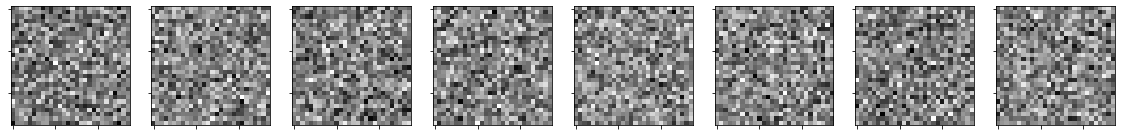

  1epoch lossD:0.17756542563438416 lossG:27.01113510131836
  2epoch lossD:0.008513235487043858 lossG:20.62273406982422
  3epoch lossD:0.060328345745801926 lossG:23.98923110961914
  4epoch lossD:0.0022122629452496767 lossG:21.644407272338867
  5epoch lossD:0.0029832241125404835 lossG:26.008480072021484


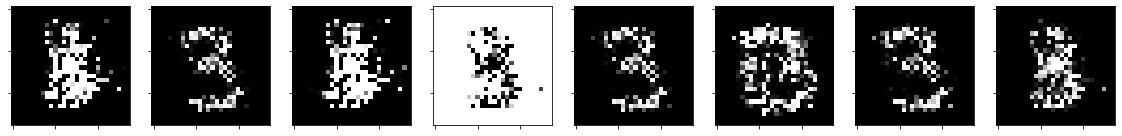

  6epoch lossD:0.005110291764140129 lossG:16.090927124023438
  7epoch lossD:0.028367746621370316 lossG:12.596107482910156
  8epoch lossD:0.035690825432538986 lossG:13.556742668151855
  9epoch lossD:0.004536656197160482 lossG:10.453058242797852
 10epoch lossD:0.04314493387937546 lossG:11.551257133483887


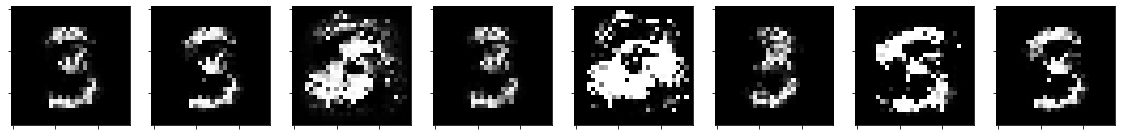

 11epoch lossD:0.025943376123905182 lossG:8.497624397277832
 12epoch lossD:0.010001462884247303 lossG:8.41125774383545
 13epoch lossD:0.1053442656993866 lossG:7.358538627624512
 14epoch lossD:0.01778794452548027 lossG:7.9856061935424805
 15epoch lossD:0.08696499466896057 lossG:7.533426284790039


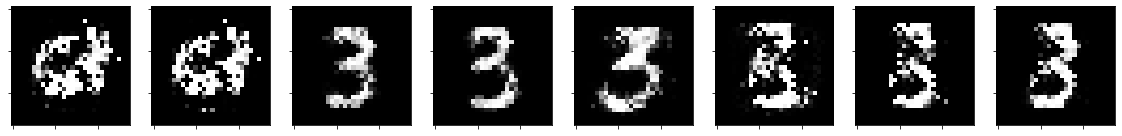

 16epoch lossD:0.10142531991004944 lossG:6.076155662536621
 17epoch lossD:0.09483975172042847 lossG:6.955157279968262
 18epoch lossD:0.12201908975839615 lossG:7.705988883972168
 19epoch lossD:0.24400870501995087 lossG:6.147154808044434
 20epoch lossD:0.21537256240844727 lossG:5.757115840911865


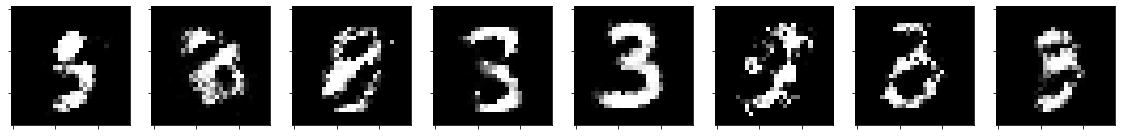

 21epoch lossD:0.14457231760025024 lossG:5.6991496086120605
 22epoch lossD:0.12669071555137634 lossG:5.418421745300293
 23epoch lossD:0.15208956599235535 lossG:6.044719219207764
 24epoch lossD:0.06263035535812378 lossG:5.551112651824951
 25epoch lossD:0.15330715477466583 lossG:5.316014766693115


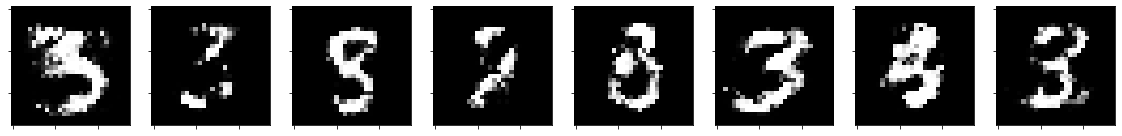

 26epoch lossD:0.28431081771850586 lossG:5.0092597007751465
 27epoch lossD:0.22992229461669922 lossG:3.6548357009887695
 28epoch lossD:0.15558744966983795 lossG:4.9917731285095215
 29epoch lossD:0.22450225055217743 lossG:4.718538761138916
 30epoch lossD:0.30190372467041016 lossG:3.7701900005340576


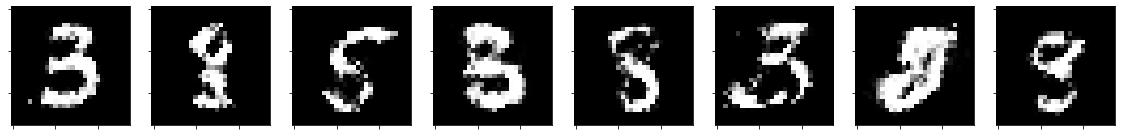

In [26]:
print('初期状態')
write(netG, w=8)
for epoch in range(epochs):
    for (image, _) in dataloader:
        optimD.zero_grad()
        optimG.zero_grad()
        lossD, lossG = train(
            netD, netG, optimD, optimG, image.cuda().reshape(-1, 784))
    print(f'{epoch+1:>3}epoch lossD:{lossD} lossG:{lossG}')
    if not (epoch + 1) % 5:
        write(netG, w=8)